In [1]:
from ROOT import TH1F, TCanvas, gStyle, TLegend, TGraph
from sklearn.externals import joblib
from array import array
import pickle
from scipy.stats import ks_2samp
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LocallyConnected1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from keras.models import load_model
from nndrone_paper.converters import BasicConverter
from nndrone_paper.models import BaseModel
import os.path

# load data
print ('Loading signal data file...')
sig_data = pd.read_hdf('/Users/sbenson/Documents/STBC-Drive/sbenson/Jets/sig_centred_imagedl.h5').head(20000)
print ('Loading background data file...')
bkg_data = pd.read_hdf('/Users/sbenson/Documents/STBC-Drive/sbenson/Jets/bkg_centred_imagedl.h5').head(20000)
#

def addRMSDev(df):
    df['phi_spread_charged'] = df.apply(lambda x: np.std(x['charged_phi']), axis = 1)
    df['eta_spread_charged'] = df.apply(lambda x: np.std(x['charged_eta']), axis = 1)
    df['phi_spread_neutral'] = df.apply(lambda x: np.std(x['neutral_phi']), axis = 1)
    df['eta_spread_neutral'] = df.apply(lambda x: np.std(x['neutral_eta']), axis = 1)
    return df

sig_data_p = addRMSDev(sig_data)
bkg_data_p = addRMSDev(bkg_data)

vars_for_training = ['kt2', 'mom', 'eta', 'phi', 'mass', 'hEnergy', 'nEnergy'
                    ,'hSumPT', 'nSumPT', 'hAvEta', 'nAvEta', 'hAvPhi', 'nAvPhi'
                    , 'phi_spread_charged', 'phi_spread_neutral', 'eta_spread_charged', 'eta_spread_neutral']

# Load classifier and scaler
scaler = joblib.load('scaler_GPDexample.pkl')
classifier = load_model('classifier_GPDexample.h5')

df_sig_train = sig_data_p.head(10000).loc[:,vars_for_training]
df_bkg_train = bkg_data_p.head(10000).loc[:,vars_for_training]
df_sig_test = sig_data_p.tail(10000).loc[:,vars_for_training]
df_bkg_test = bkg_data_p.tail(10000).loc[:,vars_for_training]

# Create the scaler to preprocess the data
df_sig_train.reindex(np.random.permutation(df_sig_train.index))
df_bkg_train.reindex(np.random.permutation(df_bkg_train.index))

sc_sig_train = scaler.transform(df_sig_train)
sc_bkg_train = scaler.transform(df_bkg_train)
sc_sig_test = scaler.transform(df_sig_test)
sc_bkg_test = scaler.transform(df_bkg_test)

train = np.append(sc_sig_train, sc_bkg_train, axis=0)
target = [1] * len(sc_sig_train) + [0] * len(sc_bkg_train)
test = np.append(sc_sig_test, sc_bkg_test, axis=0)
target_test = [1] * len(sc_sig_test) + [0] * len(sc_bkg_test)
train = np.expand_dims(train, axis=2)
test = np.expand_dims(test, axis=2)

Using TensorFlow backend.


Loading signal data file...
Loading background data file...


In [3]:
# initialize a list to store the loss value for each epoch
lossHistory = []

# Approx. control
alpha = 0.05
batchSize = 1
num_epochs = 300
threshold = 0.02
#
layerSizes = [5, 1]

converter = BasicConverter(num_epochs=num_epochs, batch_size=batchSize, learning_rate=alpha, threshold=threshold)

# convert features and outputs to np array
train = np.array(train)

# shuffle signal and background
s = np.arange(train.shape[0])
np.random.shuffle(s)
train = train[s]

# Initialise model
model = BaseModel(len(train[0]), 1)
modelloc = 'approx_GPD_temp.pkl'
histloc = 'approx_GPD_temp_history.pkl'

if os.path.exists(modelloc):
    print ("Model found, loading")
    model.load_model(modelloc)
    [losses, diffs, updates] = joblib.load(histloc)
else:
    if len(layerSizes) == 1:
        model.add_layer(1)
    else:
        for l in layerSizes:
            model.add_layer(l)

    model.print_layers()

    print("Starting stochastic conversion...")
    converter.convert_model(model, classifier, train)
    losses = converter.losses()
    diffs = converter.diffs()
    updates = converter.updates()

    model.save_model(modelloc)

    f_train = open(histloc, 'wb')
    training_data = [losses, diffs, updates]
    pickle.dump(training_data, f_train)
    f_train.close()

Model found, loading


In [25]:
# Add original decisions and drone decisions to dataframes
from copy import deepcopy
import time
def addProbs(df, cl, drone):
    df_ret = deepcopy(df)
    df_ret['prob_orig']= df.apply(lambda x: float(cl.predict_proba(np.expand_dims(x.reshape(1, -1), axis=2))[0]), axis=1)
    df_ret['prob_drone']= df.apply(lambda x: float(drone.evaluate_total(x, debug=False)), axis=1)
    return df_ret
def addProbs_l(l, cl, drone):
    print ("Adding %s probs" % len(l))
    p_orig = []
    p_drone = []
    start = time.clock()
    for x in l:
        p_orig.append(cl.predict_proba(np.expand_dims(x.reshape(1, -1), axis=2))[0].tolist()[0])
    diff = time.clock()-start
    print ("Original: Took %s seconds to evaluate %s calls: %.8f s/call" %(diff, len(l), diff/float(len(l))))
    start = time.clock()
    for x in l:
        p_drone.append(drone.evaluate_total(x, debug=False)[0][0].tolist()[0][0])
    diff = time.clock()-start
    print ("Drone: Took %s seconds to evaluate %s calls: %.8f s/call" %(diff, len(l), diff/float(len(l))))
    return p_orig, p_drone

In [5]:
def scanPoint(cutVal, sig, bkg, pname):
    totSig = len(sig)
    totBKG = len(bkg)
    sig_pass = len(sig.loc[sig[pname] > cutVal])
    bkg_rej = len(bkg.loc[bkg[pname] < cutVal])
    bkg_pass = len(bkg.loc[bkg[pname] > cutVal])
    eff_sig = float(sig_pass)/float(totSig)
    rej_bkg = float(bkg_rej)/float(totBKG)
    return eff_sig, rej_bkg, sig_pass, bkg_pass
def scanPoint_l(cutVal, sig, bkg):
    totSig = len(sig)
    totBKG = len(bkg)
    sig_pass = len([s for s in sig if s > cutVal])
    bkg_rej = len([b for b in bkg if b < cutVal])
    bkg_pass = len([b for b in bkg if b > cutVal])
    eff_sig = float(sig_pass)/float(totSig)
    rej_bkg = float(bkg_rej)/float(totBKG)
    return eff_sig, rej_bkg, sig_pass, bkg_pass
def prepPlot(_ax, xtitle, ytitle):
    _ax.grid(False)
    _ax.set_xlabel(xtitle)
    _ax.set_ylabel(ytitle)
    _ax.set_title("")

Adding 10000 probs
Original: Took 4.789156999999932 seconds to evaluate 10000 calls: 0.00047892 s/call
Drone: Took 0.6214680000000499 seconds to evaluate 10000 calls: 0.00006215 s/call
Adding 10000 probs
Original: Took 4.744509999999991 seconds to evaluate 10000 calls: 0.00047445 s/call
Drone: Took 0.6281249999999545 seconds to evaluate 10000 calls: 0.00006281 s/call
[0.71089106798172, 0.8037771582603455, 0.7273904085159302, 0.3853767514228821, 0.4052496552467346]
[0.2825843393802643, 0.3246588110923767, 0.3885851204395294, 0.5627346038818359, 0.14637237787246704]
[0.7368840857019666, 0.8133472266044269, 0.743243268413667, 0.415799135163671, 0.4010204043943797]
[0.27260440260581925, 0.3311587135317048, 0.35924121303191414, 0.5499488779713627, 0.16106993238366477]


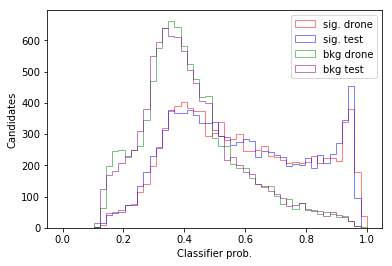

In [27]:
# Make outputs
#print(df_sig_test)
sig_tst_o, sig_tst_d = addProbs_l(sc_sig_test, classifier, model)
bkg_tst_o, bkg_tst_d = addProbs_l(sc_bkg_test, classifier, model)

bins_pr = np.linspace(0, 1, 50)
fig, ax1 = plt.subplots()

h_sig_drone = plt.hist(np.array(sig_tst_d), fill=False, edgecolor = 'red', bins = bins_pr, alpha=0.5, label="sig. drone", histtype='step')
h_sig_test = plt.hist(np.array(sig_tst_o), fill=False, edgecolor = 'blue', bins = bins_pr, alpha=0.5, label="sig. test", histtype='step')
h_bkg_drone = plt.hist(np.array(bkg_tst_d), edgecolor = 'green', fill=False, bins = bins_pr, alpha=0.5, label="bkg drone", histtype='step')
h_bkg_test = plt.hist(np.array(bkg_tst_o), fill=False, edgecolor = 'purple', bins = bins_pr, alpha=0.5, label="bkg test", histtype='step')
prepPlot(ax1, "Classifier prob.", "Candidates")
plt.legend()
plt.savefig('output_comp_drone_gpd.png')
plt.show()

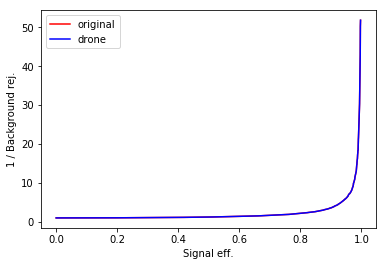

In [37]:
# Plot ROC comparison & FoM optimisation
eff_sig_drone = []
eff_sig_test = []
rej_bkg_drone = []
rej_bkg_test = []
#
scanpoints = np.linspace(0.15, 0.001, 1000)
scanpoints += np.linspace(0.001, 1.0, 1000)
for s in scanpoints:
    es, rb, nSig, nBKG = scanPoint_l(s, sig_tst_o, bkg_tst_o)
    es_dr, rb_dr, nSig_dr, nBKG_dr = scanPoint_l(s, sig_tst_o, bkg_tst_o)
    eff_sig_test.append(es)
    rej_bkg_test.append(1/rb)
    eff_sig_drone.append(es_dr)
    rej_bkg_drone.append(1/rb_dr)

fig, axes = plt.subplots()
plt1 = axes.plot(eff_sig_test, rej_bkg_test, 'r-', label = 'original')
plt2 = axes.plot(eff_sig_drone, rej_bkg_drone, 'b-', label= 'drone')
plt.legend()
prepPlot(axes, "Signal eff.", "1 / Background rej.")
plt.savefig('roc_gpd.pdf')
plt.show()

Number of model additions: 10


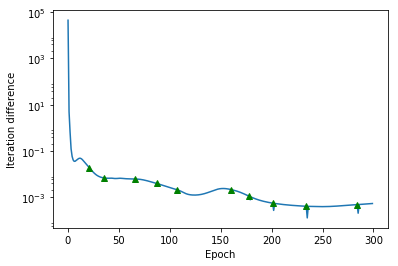

In [36]:
# Plot difference history
training = [losses, diffs, updates]
count = [n for n in range(len(training[0]))]
fig = plt.figure()
plt.plot(count, training[1], '-')
# Add markers where an update occurs
markers_x = [c for c, a in zip(count, training[2]) if a == 1]
markers_y = [d for d, a in zip(training[1], training[2]) if a == 1]
print('Number of model additions: %s' % len(markers_x))
plt.plot(markers_x, markers_y, 'g^')
fig.suptitle("")
plt.xlabel("Epoch")
plt.ylabel("Iteration difference")
plt.yscale('log')
plt.savefig("diff_history_gpd.pdf")
plt.show()
plt.clf()

In [38]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 16, 90)            4320      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________
